# Projeto de Implementação - Aprendizado Profundo
## Integrantes:
Ian Marques Breda 

Kaio Henrique Avelino Domeni de Paulo
## Professor:
Denis Henrique Pinheiro Salvadeo

## Tema:

## Objetivos:

## Instruções:

## Última alteração:

### Importação das bibliotecas

Aqui são realizados os _imports_ das bibliotecas importantes para o desenvolvimento do projeto. Os _imports_ relacionados ao Pytorch são responsáveis pela criação, importação e alteração dos modelos de redes neurais, bem como o tratamento das imagens da base de dados.

_Imports_ relacionados ao numpy e scikit-learn são relacionados à avalição de cada modelo a partir de métricas selecionadas, incluindo o PCA.

Demais _imports_ como matplot e seaborn servem para a construção dos gráficos e visualização das métricas selecionadas.

In [48]:
import torch
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset

import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from tqdm import tqdm
import pandas as pd
from PIL import Image

### _Download_ do _dataset_

Aqui são baixados os arquivos referente ao _dataset_ escolhido, FairFace, diretamente do Kaggle. Rode este trecho de código apenas se o _dataset_ não estiver baixado em sua máquina.

In [ ]:
# Biblioteca do Kaggle
# import kagglehub

# # Download da versão mais recente
# path = kagglehub.dataset_download("aibloy/fairface")

# print("Path to dataset files:", path)

Path to dataset files: C:\Users\Kaio\.cache\kagglehub\datasets\aibloy\fairface\versions\1


### Transformação

Neste trecho do código, nós criamos uma função para transformar todas as imagens para o padrão 224x224 pixels.

In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Montando o _Dataset_

A base FairFace é composta por imagens associadas à um arquivo CSV que contém características do indivíduo da imagem, como raça, gênero, idade... Portanto, vamos utilizar a classe abaixo para montar um _dataset_ a partir das características que desejamos voltadas para o DEIA.

In [26]:
class FairFaceDataset(Dataset):
    # Por padrão, o target é "race", ou seja, a raça, mas isso pode ser alterado na
    # célula seguinte.
    def __init__(self, csv_path, img_dir, transform=None, target="race"):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        self.target = target
        
        # Mapear rótulos (ex.: raça → índice)
        self.label_map = {label: idx for idx, label in enumerate(sorted(self.data[target].unique()))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = f"{self.img_dir}/{row['file']}"
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = self.label_map[row[self.target]]
        return img, label

### Carregando o _Dataset_

A partir da classe anterior, carregamos o _dataset_ com as características desejadas para a análise.

In [ ]:
dataset = FairFaceDataset(
    csv_path="FairFace/train_labels.csv",
    img_dir="FairFace/",
    transform=transform,
    target="race" # Também pode ser "age" para idade.
)

# Loader do dataset
loader = DataLoader(dataset, batch_size=64, shuffle=False)

### Carregar modelo

Aqui definimos a função que carrega os modelos testados da biblioteca models. Utilizamos a variável model_name para identificar a rede a ser carregada na execução corrente. Mude com base na rede que queira utilizar.

In [36]:
def load_model(model_name):
    if model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        model.fc = torch.nn.Identity()

    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.classifier = torch.nn.Identity()

    elif model_name == "mobilenet_v3":
        model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
        model.classifier = torch.nn.Identity()

    elif model_name == "convnext_tiny":
        model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        model.classifier = torch.nn.Identity()

    elif model_name == "vit_b_16":
        model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
        model.heads = torch.nn.Identity()

    else:
        raise ValueError("Modelo desconhecido!")

    return model.cuda().eval()


### Extração de embedding

A função abaixo tem o objetivo de extrair os embeddings das imagens da base de dados.

In [37]:
def extract_embeddings(model, loader):
    all_emb = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs = imgs.cuda()
            feats = model(imgs)
            all_emb.append(feats.cpu().numpy())
            all_labels.append(labels.numpy())

    embeddings = np.concatenate(all_emb)
    labels = np.concatenate(all_labels)
    return embeddings, labels

### Extração pelo modelo

Neste trecho de código, extraímos o embedding com uma rede escolhida na função "load_model". É importante ajustar o batch size nas células anteriores para que seja compatível com a GPU onde o processo será executado.

In [38]:
model = load_model('resnet50')

embeddings, labels = extract_embeddings(model, loader)

100%|██████████| 1356/1356 [05:09<00:00,  4.38it/s]


### Obtendo os rótulos

Este trecho serve apenas para adquirir o nome dos rótulos com os quais estamos trabalhando. Por exemplo, se a extração dos _embeddings_ for feita utilizando "race", vamos obter rótulos do tipo "white", "black", "asian" e assim por diante.

In [43]:
inv_label_map = {v: k for k, v in dataset.label_map.items()}

### Elaboração do PCA

_Principal Component Analysis_ é uma técnica linear de redução de dimensionalidade. Ele gera um mapa onde cada ponto é uma imagem representada pelo _embedding_. Se os grupos estiverem visualmente separados, o modelo está capturando diferenças fortes entre eles.

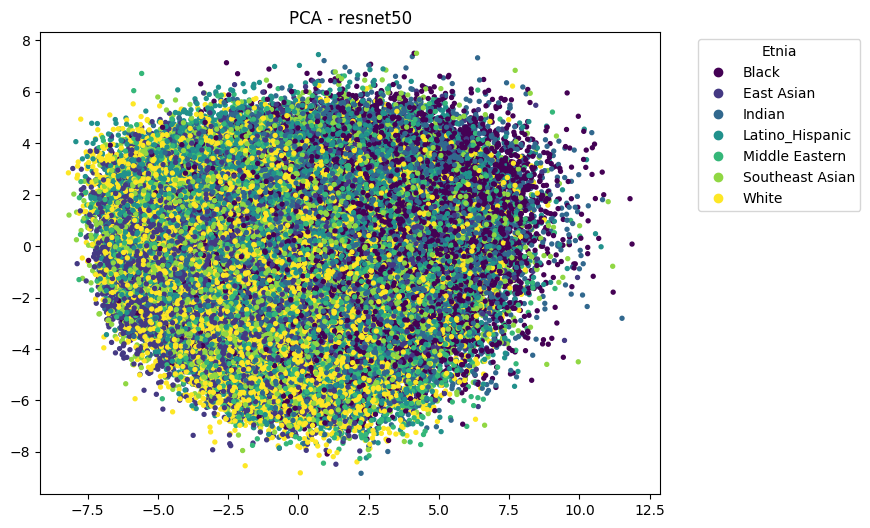

In [ ]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

# Informações do Plot, como tamanho, cor e título
plt.figure(figsize=(8, 6))
scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], 
                      c=labels, s=8, cmap='viridis')
plt.title(f'PCA - {model_name}')

# Coloca as legendas com base nos rótulos obtidos na célula anterior.
handles, _ = scatter.legend_elements()
plt.legend(handles, [inv_label_map[i] for i in range(len(handles))],
           title='Etnia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Gráfico de frequência

Neste trecho de código é elaborado um gráfico de barras veticais simples que mostra a frequência de cada rótulo (raça, gênero ou idade) no _dataset_.

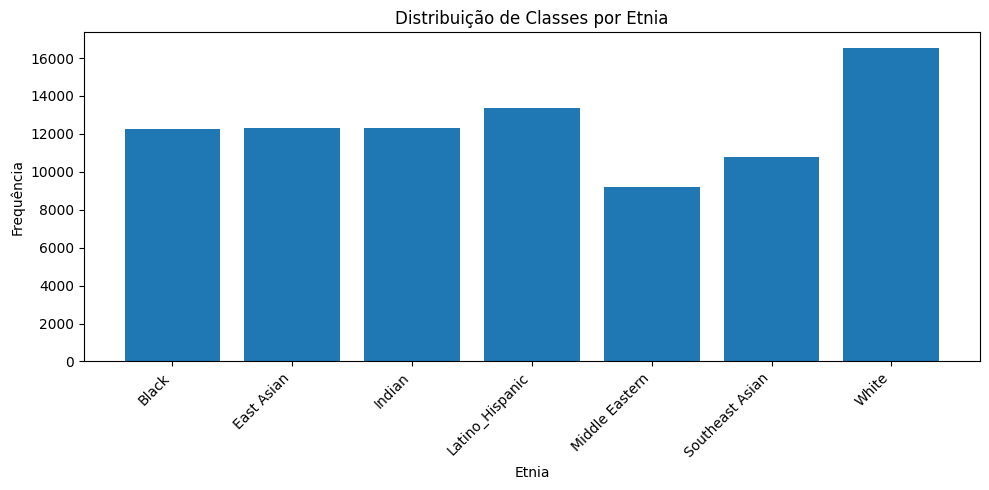

In [47]:
unique, counts = np.unique(labels, return_counts=True)

race_names = [inv_label_map[i] for i in unique]

plt.figure(figsize=(10,5))
plt.bar(race_names, counts)
plt.xticks(rotation=45, ha="right")
plt.title("Distribuição de Classes por Etnia")
plt.xlabel("Etnia")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

### Entropia

Aqui é calculada a entropia do _dataset_ (verificar se é relevante).

In [41]:
p = counts / counts.sum()
entropy = -np.sum(p * np.log2(p))
entropy

np.float64(2.7871039867173315)

### Elaboração do UMAP

_Uniform Manifold Approximation and Projection_ é uma técnica não-linear que criar representações 2D mais expressivas que o PCA (idealmente). Os grupos podem ficar mais agrupados do que no PCA, pois o UMAP força uma estrutura geométrica que melhor representa a similaridade entre _embeddings_.

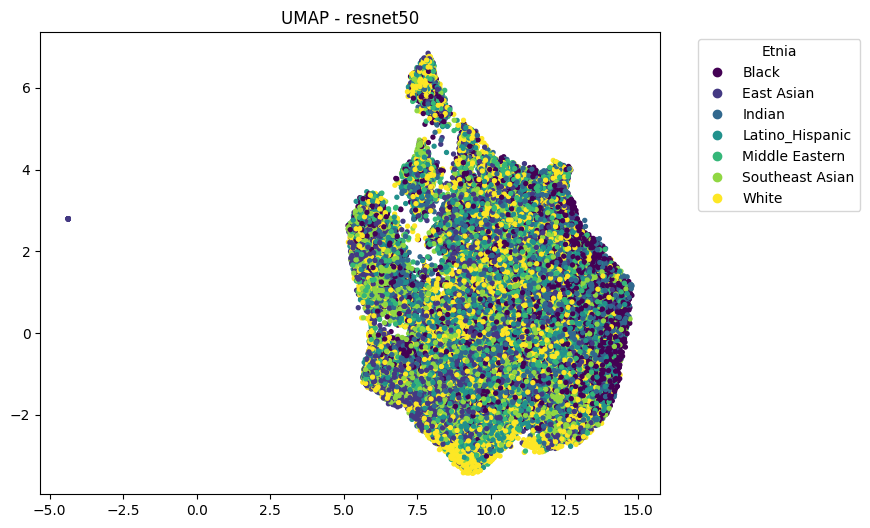

In [46]:
reducer = umap.UMAP()
umap_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(umap_2d[:,0], umap_2d[:,1], 
                      c=labels, s=8, cmap='viridis')
plt.title(f"UMAP - {model_name}")

handles, _ = scatter.legend_elements()
plt.legend(handles, [inv_label_map[i] for i in range(len(handles))],
           title="Etnia", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Métricas de agrupamento (_clustering_)

Neste trecho de código, são calculadas as métricas referentes à qualidade do agrupamento realizado pela rede testada. As métricas selecionadas foram a _Silhouette Score_ que vai de -1 a 1, onde -1 indica um _cluster_ ruim, 0 indica mistura e 1 indica boa separabilidade; _Davies-Boulding Index_, que quanto menor, melhor a separação; e _Calinski-Harabasz Index_, que quanto maior, melhor a separação entre os centróides (o que não quer dizer que houve realmente boa separação).

In [ ]:
# Silhouette Score
silhouette = silhouette_score(embeddings, labels)

# Davies-Bouldin Index
dbi = davies_bouldin_score(embeddings, labels)

# Calinski-Harabasz Index
chi = calinski_harabasz_score(embeddings, labels)

# Mostra as métricas calculadas
print("===== Separabilidade das Raças nos Embeddings =====")
print(f"Silhouette Score:           {silhouette:.4f}   (maior = melhor)")
print(f"Davies-Bouldin Index:       {dbi:.4f}   (menor = melhor)")
print(f"Calinski-Harabasz Score:    {chi:.4f}   (maior = melhor)")

===== Separabilidade das Raças nos Embeddings =====
Silhouette Score:           -0.0130   (maior = melhor)
Davies-Bouldin Index:       13.1891   (menor = melhor)
Calinski-Harabasz Score:    408.8901   (maior = melhor)
